In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.convtools import compute_output_shape, conviter
import scipy as sp

In [2]:
# very simple function to plot history of the model training

def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

# class Fourier(nn.Module):
#     def __init__(self, n_points, n_components, bias=True):
#         super().__init__()
#         self.n_points = n_points
#         self.n_components = n_components
#         self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
#         self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
#         self.a0 = nn.Parameter(torch.empty(self.n_points, 1))
#         self.reset_parameters()

#     def reset_parameters(self) -> None:
#         init.uniform_(self.a, -0.01, 0.01)
#         init.uniform_(self.b, -0.01, 0.01)
#         init.uniform_(self.a0, -0.01, 0.01)

#     def forward(self, x):
#         out = (x@self.a0)/(2*self.n_points)*torch.ones_like(x)

#         for n in range(self.n_components):
#             out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

#         return out

class Fourier(nn.Module):
    def __init__(self, n_points, n_components, bias=True):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.a0 = nn.Parameter(torch.empty(self.n_points, 1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        # out = (x@self.a0)/(2*self.n_points)*torch.ones_like(x)

        # for n in range(self.n_components):
        #     out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

        out = (x@self.a0)/2*torch.ones_like(x)

        for n in range(self.n_components):
            out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points - (x@self.b[:, n]))

        return out


class FourierNet(BaseModel):

    def __init__(self, n_points, n_components, n_functions):
        super().__init__()
        self.layers = nn.ModuleList([Fourier(n_points, n_components) for _ in range(n_functions)])
        self.layer = Fourier(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x
        # out = torch.zeros_like(x)
        # for layer in self.layers:
        #     out += layer(x)
        # return out



In [4]:
class Power(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components))
        self.c = nn.Parameter(torch.empty(self.n_points))


        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.c, -0.01, 0.01)

    def forward(self, x):
        out = torch.zeros_like(x)
        for n in range(self.n_components):
            out += (self.a[:, n])*(x - self.c)**n

        return out


class PowerNet(BaseModel):

    def __init__(self, n_points, n_components):
        super().__init__()
        self.layer = Power(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x

In [15]:
# fun = lambda x: x**5
# fun = lambda x: np.sin(2*np.pi/x)
# fun = lambda x: np.sin(10*x)*x
# fun = lambda x: 2.321 + 1.013*(x + 1.212) + 1.232*(x - 1.21321)**2 + 0.123*(x + 3.2112)**3 - 2.3112*x**4
# fun = lambda x: np.tanh(x)
fun = lambda x: np.exp(-x**2)
# fun = lambda x: np.exp(np.sin(x) + np.cos(x))
# fun = lambda x: np.sin(10*x) * np.sin(100*x)# + .8*np.cos(.3*x) + 0.9*np.sin(9*x)
# fun = lambda x: 4/np.pi*(np.sin(x) + 1/3*np.sin(3*x) + 1/5*np.sin(5*x) + 1/7*np.sin(7*x) + 1/9*np.sin(9*x))

In [42]:
n_points = 50

X = sp.stats.zscore(np.array([gaussian_random_walk(n_points) for _  in range(1000)]))
# X = np.array([gaussian_random_walk(n_points) for _  in range(1000)])
# X = (X - X.min(keepdims=True))/(X.max(keepdims=True) - X.min(keepdims=True))
Y = fun(X)

dataset = EpochsDataset(
    (
        X, Y
        # np.expand_dims(X, -1),
        # np.expand_dims(Y, -1)
    ),
    savepath='../datasets/exp',
    # transform=zscore,
    # target_transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])
X, y = next(iter(DataLoader(train, len(train))))

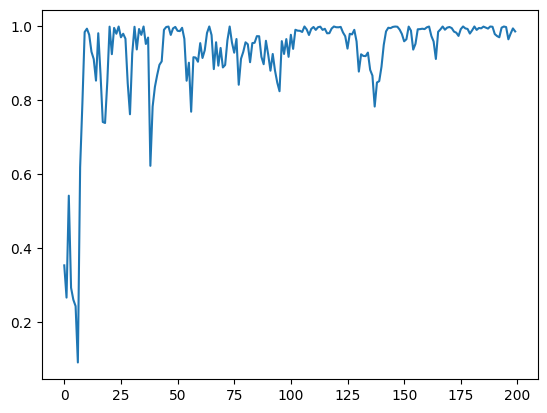

In [26]:
plt.plot(Y[0])

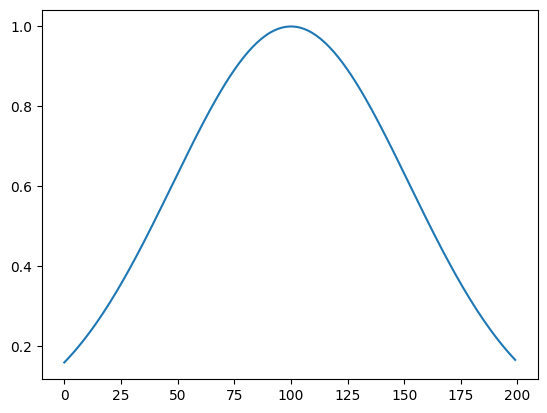

In [27]:
t = np.linspace(X.numpy().min(1).mean(), X.numpy().max(1).mean(), X.shape[1])

plt.plot(fun(t))

In [292]:
y.min(), y.max()

(tensor(-761.6385), tensor(1425.1876))

In [13]:
FourierNet(n_points, 50, 10).state_dict().keys()

odict_keys(['layers.0.a', 'layers.0.b', 'layers.0.a0', 'layers.1.a', 'layers.1.b', 'layers.1.a0', 'layers.2.a', 'layers.2.b', 'layers.2.a0', 'layers.3.a', 'layers.3.b', 'layers.3.a0', 'layers.4.a', 'layers.4.b', 'layers.4.a0', 'layers.5.a', 'layers.5.b', 'layers.5.a0', 'layers.6.a', 'layers.6.b', 'layers.6.a0', 'layers.7.a', 'layers.7.b', 'layers.7.a0', 'layers.8.a', 'layers.8.b', 'layers.8.a0', 'layers.9.a', 'layers.9.b', 'layers.9.a0', 'layer.a', 'layer.b', 'layer.a0', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked'])

In [21]:
FourierNet(n_points, 10, 10)(X)

tensor([[ 0.0052,  0.0077,  0.0131,  ...,  0.0135,  0.0135,  0.0135],
        [-0.1391, -0.1379, -0.1367,  ..., -0.1333, -0.1337, -0.1336],
        [-0.3429, -0.3382, -0.3379,  ..., -0.3291, -0.3286, -0.3273],
        ...,
        [-0.1915, -0.1905, -0.1893,  ..., -0.1951, -0.1951, -0.1943],
        [ 0.3080,  0.3082,  0.3074,  ...,  0.3075,  0.3074,  0.3074],
        [-0.1303, -0.1382, -0.1407,  ..., -0.1401, -0.1406, -0.1405]],
       grad_fn=<AddBackward0>)

In [43]:
model = FourierNet(n_points, n_points, 50)

optimizer = torch.optim.Adam
loss = torch.nn.MSELoss()
loss = nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = ('mse', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            ['layer.a0', 'layer.a', 'layer.b'],
            0.001
        )
    ]
)

In [44]:
model.trainer.epoch_number = 0

Epoch 0:  loss_train:  0.6827   |    mse_train:  0.6821   |    loss_val:  0.6169   |    mse_val:  0.6162
Epoch 1:  loss_train:  0.6449   |    mse_train:  0.6442   |    loss_val:  0.7080   |    mse_val:  0.7073
Epoch 2:  loss_train:  0.6269   |    mse_train:  0.6262   |    loss_val:  0.6571   |    mse_val:  0.6564
Epoch 3:  loss_train:  0.5976   |    mse_train:  0.5969   |    loss_val:  0.6222   |    mse_val:  0.6215
Epoch 4:  loss_train:  0.5917   |    mse_train:  0.5910   |    loss_val:  0.6400   |    mse_val:  0.6392
Epoch 5:  loss_train:  0.5706   |    mse_train:  0.5698   |    loss_val:  0.6053   |    mse_val:  0.6046
Epoch 6:  loss_train:  0.5562   |    mse_train:  0.5554   |    loss_val:  0.6011   |    mse_val:  0.6003
Epoch 7:  loss_train:  0.5481   |    mse_train:  0.5473   |    loss_val:  0.5792   |    mse_val:  0.5784
Epoch 8:  loss_train:  0.5309   |    mse_train:  0.5301   |    loss_val:  0.5674   |    mse_val:  0.5665
Epoch 9:  loss_train:  0.5163   |    mse_train:  0.5154

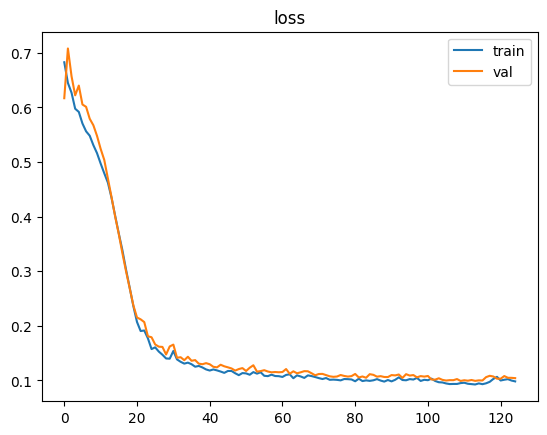

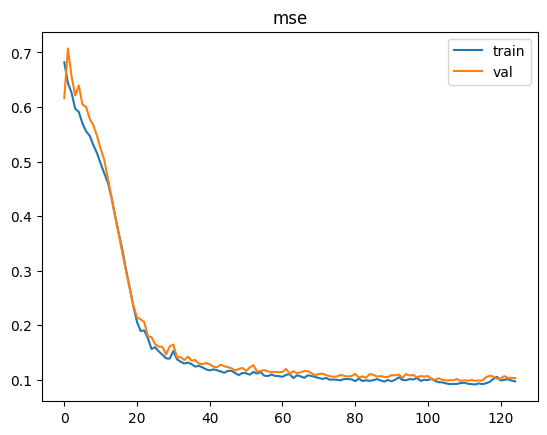

In [45]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [46]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.08975518047809601
train_mse: 0.0885112687945366
loss: 0.09365112408995628
mse: 0.09240721240639686


In [47]:
X, y = next(iter(DataLoader(test, len(test))))
y_pred = model(X)
y_pred = y_pred.detach().numpy()

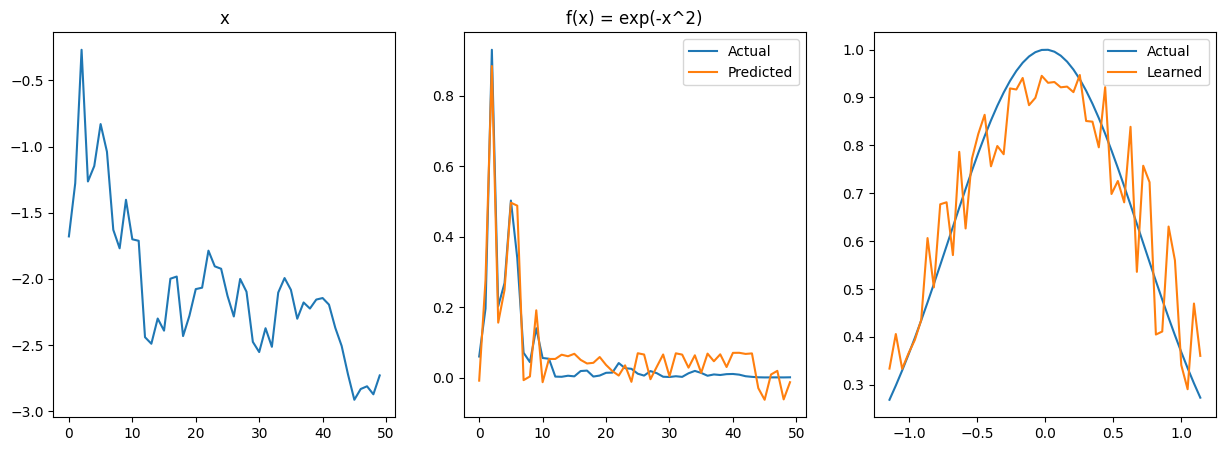

In [48]:
i = np.random.randint(0, y_pred.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(X[i])
ax1.set_title('x')
ax2.plot(y[i])
ax2.set_title('f(x) = exp(-x^2)')
ax2.plot(y_pred[i])
ax2.legend(['Actual', 'Predicted'], loc='upper right')

t = np.linspace(X.numpy().min(1).mean(), X.numpy().max(1).mean(), X.shape[1])
ax3.plot(t, fun(t))
ax3.plot(t, model(torch.Tensor(np.expand_dims(t, 0))).detach()[0])
ax3.legend(['Actual', 'Learned'], loc='upper right')

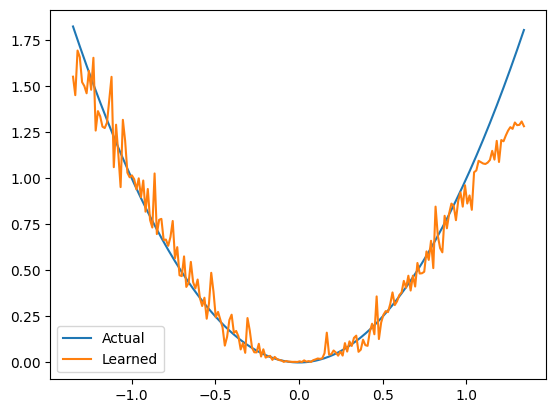

In [397]:
model = PowerNet(n_points, 5)

optimizer = torch.optim.Adam
loss = torch.nn.MSELoss()
# loss = nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = ('mse', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        # L2Reg(
        #     ['layer.a0', 'layer.a', 'layer.b'],
        #     0.01
        # )
    ]
)

In [17]:
import numpy as np

x = 2*np.random.random(10) - 1
e = 2*np.random.random(10) - 1

In [48]:
A = np.array([
    x,
    x + e,
    x + 2*e,
    x + 8*e,
    x + 512*e
])

B = np.array([
    x + 512*e,
    x + 8*e,
    x + 2*e,
    x + e,
    x
])

In [46]:
np.cov(x,
    x + e)

array([[0.28823851, 0.41396102],
       [0.41396102, 0.81918753]])

In [53]:
np.corrcoef(A, B)

array([[1.        , 0.8519062 , 0.72751803, 0.53643521, 0.44453026,
        0.44453026, 0.53643521, 0.72751803, 0.8519062 , 1.        ],
       [0.8519062 , 1.        , 0.97907786, 0.89895992, 0.84780459,
        0.84780459, 0.89895992, 0.97907786, 1.        , 0.8519062 ],
       [0.72751803, 0.97907786, 1.        , 0.9692849 , 0.9379771 ,
        0.9379771 , 0.9692849 , 1.        , 0.97907786, 0.72751803],
       [0.53643521, 0.89895992, 0.9692849 , 1.        , 0.99443396,
        0.99443396, 1.        , 0.9692849 , 0.89895992, 0.53643521],
       [0.44453026, 0.84780459, 0.9379771 , 0.99443396, 1.        ,
        1.        , 0.99443396, 0.9379771 , 0.84780459, 0.44453026],
       [0.44453026, 0.84780459, 0.9379771 , 0.99443396, 1.        ,
        1.        , 0.99443396, 0.9379771 , 0.84780459, 0.44453026],
       [0.53643521, 0.89895992, 0.9692849 , 1.        , 0.99443396,
        0.99443396, 1.        , 0.9692849 , 0.89895992, 0.53643521],
       [0.72751803, 0.97907786, 1.       

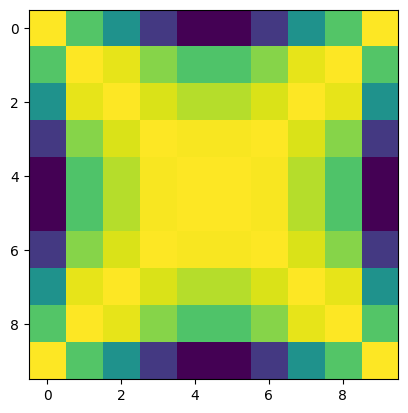

In [54]:
import matplotlib.pyplot as plt

plt.imshow(np.corrcoef(A, B))

In [398]:
model.trainer.epoch_number = 0

Epoch 0:  loss_train:  131.6999   |    mse_train:  1.3754   |    loss_val:  10.7023   |    mse_val:  0.6814
Epoch 1:  loss_train:  48.3450   |    mse_train:  0.9420   |    loss_val:  4.5339   |    mse_val:  0.5884
Epoch 2:  loss_train:  16.2655   |    mse_train:  0.7452   |    loss_val:  2.7147   |    mse_val:  0.5535
Epoch 3:  loss_train:  8.1835   |    mse_train:  0.7023   |    loss_val:  2.3150   |    mse_val:  0.5412
Epoch 4:  loss_train:  8.8546   |    mse_train:  0.7151   |    loss_val:  2.0662   |    mse_val:  0.5324
Epoch 5:  loss_train:  9.7401   |    mse_train:  0.6951   |    loss_val:  1.7112   |    mse_val:  0.5181
Epoch 6:  loss_train:  8.9824   |    mse_train:  0.6596   |    loss_val:  1.3640   |    mse_val:  0.5025
Epoch 7:  loss_train:  7.0083   |    mse_train:  0.6180   |    loss_val:  1.1174   |    mse_val:  0.4856
Epoch 8:  loss_train:  4.6384   |    mse_train:  0.5738   |    loss_val:  0.9428   |    mse_val:  0.4714
Epoch 9:  loss_train:  2.8322   |    mse_train:  0

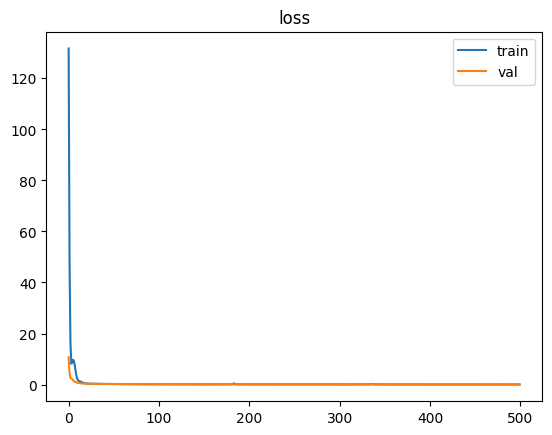

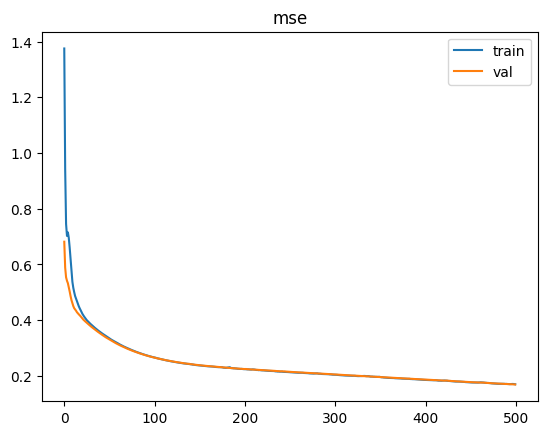

In [399]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [400]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.0592590220272541
train_mse: 0.1709793508052826
loss: 0.22648873329162597
mse: 0.17995688915252686


In [401]:
X, y = next(iter(DataLoader(test, len(test))))
y_pred = model(X)
y_pred = y_pred.detach().numpy()

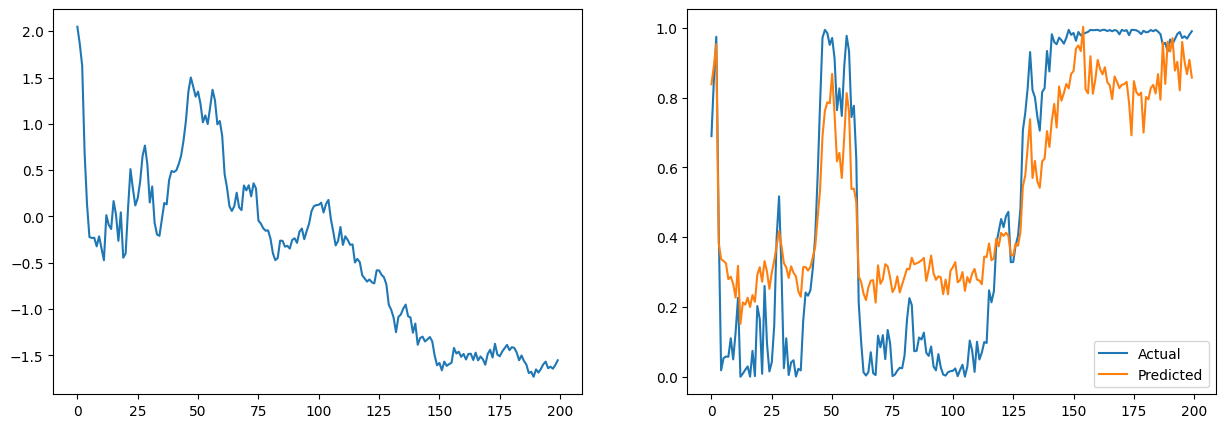

In [408]:
i = np.random.randint(0, y_pred.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(X[i])
ax2.plot(y[i])
ax2.plot(y_pred[i])
plt.legend(['Actual', 'Predicted'])

In [409]:
t = np.linspace(X.numpy().min(1).mean(), X.numpy().max(1).mean(), X.shape[1])

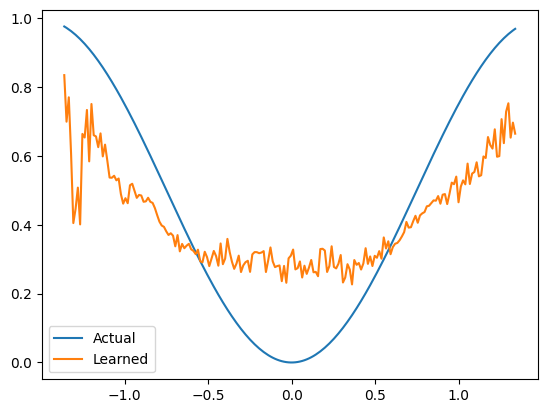

In [410]:
plt.plot(t, fun(t))
plt.plot(t, model(torch.Tensor(np.expand_dims(t, 0))).detach()[0])
plt.legend(['Actual', 'Learned'])

In [8]:
n_points = 200

# X = sp.stats.zscore(np.array([gaussian_random_walk(n_points) for _  in range(1000)]))
X = np.expand_dims(gaussian_random_walk(1000), 1)
Y = fun(X)

dataset = EpochsDataset(
    (
        X, Y
        # np.expand_dims(X, -1),
        # np.expand_dims(Y, -1)
    ),
    savepath='../datasets/exp',
    # transform=zscore,
    # target_transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])
X, y = next(iter(DataLoader(train, len(train))))

In [5]:
import math

class Taylor(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.d = nn.Parameter(torch.empty(1, self.n_components, 1))
        self.x0 = nn.Parameter(torch.empty(1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.d, -0.01, 0.01)
        init.uniform_(self.x0, -0.01, 0.01)

    def forward(self, x):
        a = x*self.x0

        out = 0
        for n in range(self.n_components):
            out += ( (x - a)**n )*( ( x*self.d[:, n] ) / math.factorial(n) )

        return out.sum(1, keepdim=True)

In [6]:
class TaylorNet(BaseModel):

    def __init__(self, n_components):
        super().__init__()
        self.layer = Taylor(n_components)

    def forward(self, x):
        x = self.layer(x)
        return x

In [102]:
X.shape

torch.Size([700, 1])

In [103]:
y.min(), y.max()

(tensor(-8920639.), tensor(11.6138))

In [109]:
TaylorNet(5)(X).shape

torch.Size([700, 1])

In [9]:
model = TaylorNet(10)

optimizer = torch.optim.Adam
loss = torch.nn.MSELoss()
# loss = nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = ('mse', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        # L2Reg(
        #     ['layer.a0', 'layer.a', 'layer.b'],
        #     0.01
        # )
    ]
)

Epoch 0:  loss_train:  52865307989.3333   |    mse_train:  153476.9115   |    loss_val:  49277046784.0000   |    mse_val:  158743.0859
Epoch 1:  loss_train:  50417179306.6667   |    mse_train:  152280.6979   |    loss_val:  49218487637.3333   |    mse_val:  157597.7734
Epoch 2:  loss_train:  48589187754.6667   |    mse_train:  151680.6615   |    loss_val:  51312032426.6667   |    mse_val:  159639.9688
Epoch 3:  loss_train:  48700512938.6667   |    mse_train:  153608.7188   |    loss_val:  52895965184.0000   |    mse_val:  162350.4948
Epoch 4:  loss_train:  48808259584.0000   |    mse_train:  154294.8281   |    loss_val:  52034603690.6667   |    mse_val:  161104.2083
Epoch 5:  loss_train:  47940364970.6667   |    mse_train:  152836.2448   |    loss_val:  49901984426.6667   |    mse_val:  157459.9531
Epoch 6:  loss_train:  47082962944.0000   |    mse_train:  150801.6875   |    loss_val:  48317913770.6667   |    mse_val:  155849.9974
Epoch 7:  loss_train:  46900116138.6667   |    mse_trai

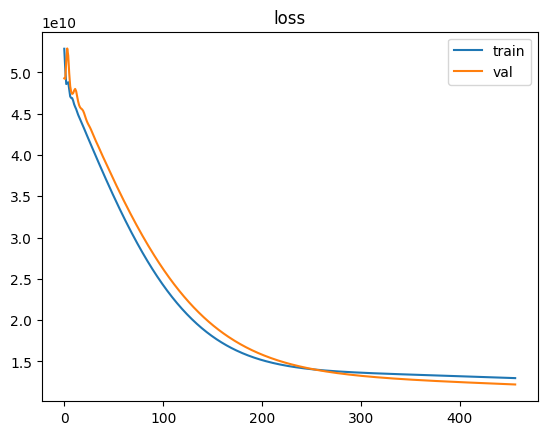

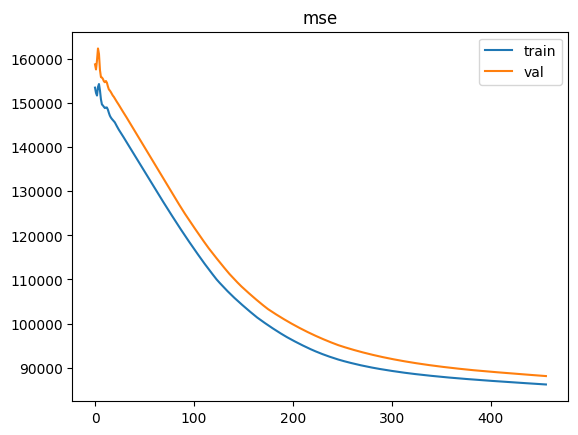

In [12]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [13]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 12856250675.2
train_mse: 86519.76484375
loss: 10224278374.4
mse: 78597.994140625
